<a href="https://colab.research.google.com/github/cmunozcortes/c247-final-project/blob/main/src/RaSCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import datetime

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, initializers, regularizers
import tensorflow.keras.backend as K

# fix CUDNN_STATUS_INTERNAL_ERROR
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Perform PCA
do_pca = False

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [41]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/c247")

# Load the data and convert from 64 to 32 bit floats
X_train_valid = np.load("data/X_train_valid.npy").astype(np.float32)
y_train_valid = np.load("data/y_train_valid.npy").astype(np.float32)
person_train_valid = np.load("data/person_train_valid.npy").astype(np.float32)
X_test = np.load("data/X_test.npy").astype(np.float32)
y_test = np.load("data/y_test.npy").astype(np.float32)
person_test = np.load("data/person_test.npy").astype(np.float32)

# Print our the shapes of the data we loaded for confirmation
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

# Function to convert labels from single value class index to onehot vector
def convert_to_one_hot(in_arr):
    in_arr = in_arr.reshape((in_arr.shape[0],))
    in_arr = in_arr.astype(int)
    in_arr_1h = np.zeros((in_arr.size, in_arr.max()+1))
    in_arr_1h[np.arange(in_arr.size),in_arr] = 1
    return in_arr_1h

# Adjust the y labels to be in the range [0-3] and also generate equivalent onehot representations
y_train_valid -= 769
y_test -= 769
print('y_train_valid:', y_train_valid[:10])
print('y_test:', y_train_valid[:10])
y_train_valid_1h = convert_to_one_hot(y_train_valid)
y_test_1h = convert_to_one_hot(y_test)
person_train_valid_1h = convert_to_one_hot(person_train_valid) # TODO remove?
person_test_1h = convert_to_one_hot(person_test) # TODO remove?
print('y_train_valid_1h:')
print(y_train_valid_1h[:4])
print('y_test_1h:')
print(y_train_valid_1h[:4])

# TODO REVIEW: Do we want to include data regarding subject classification?

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
y_train_valid: [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]
y_test: [2. 3. 0. 0. 0. 0. 2. 1. 3. 3.]
y_train_valid_1h:
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
y_test_1h:
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


## Data Augmentation

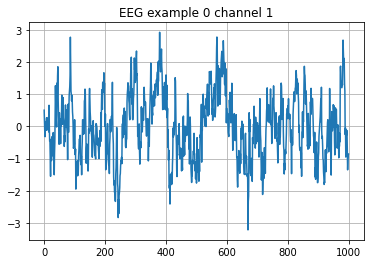

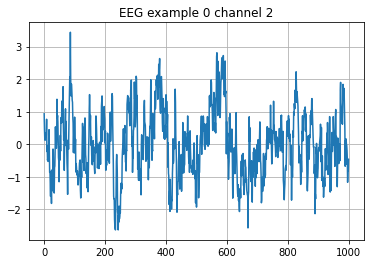

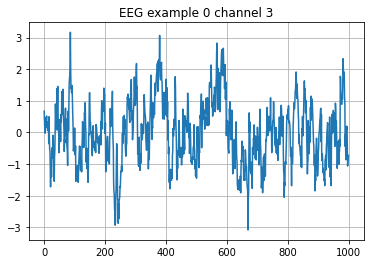

In [42]:
# Trim all time series to the first 500 samples (2 seconds @ fs=250Hz)
#X_train_valid = X_train_valid[:,:,:500]
#X_test = X_test[:,:,:500]

# Normalize each time series signal of each channel to have zero mean and unit variance
# This is fine to do on the test set, since it is independent of example
X_train_valid -= np.expand_dims(np.mean(X_train_valid, axis=-1), -1)
X_test -= np.expand_dims(np.mean(X_test, axis=-1), -1)
X_train_valid /= np.expand_dims(np.std(X_train_valid, axis=-1), -1)
X_test /= np.expand_dims(np.std(X_test, axis=-1), -1)

# Generate some plots to visually verify
for i in range(3):
    plt.title("EEG example 0 channel %d" % (i+1))
    plt.plot(X_train_valid[0,i,:])
    plt.grid()
    plt.show()

In [43]:
class AttentionLSTMIn(keras.layers.LSTM):
    """
    Keras LSTM layer (all keyword arguments preserved) with the addition of attention weights

    Attention weights are calculated as a function of the previous hidden state to the current LSTM step.
    Weights are applied either locally (across channels at current timestep) or globally (weight each sequence element
    of each channel).
    """
    ATT_STYLES = ['local', 'global']

    def __init__(self, units, alignment_depth: int = 1, style='local', alignment_units=None, implementation=2,
                 **kwargs):
        implementation = implementation if implementation > 0 else 2
        alignment_depth = max(0, alignment_depth)
        if isinstance(alignment_units, (list, tuple)):
            self.alignment_units = [int(x) for x in alignment_units]
            self.alignment_depth = len(self.alignment_units)
        else:
            self.alignment_depth = alignment_depth
            self.alignment_units = [alignment_units if alignment_units else units for _ in range(alignment_depth)]
        if style not in self.ATT_STYLES:
            raise TypeError('Could not understand style: ' + style)
        else:
            self.style = style
        super(AttentionLSTMIn, self).__init__(units, implementation=implementation, **kwargs)

    def build(self, input_shape):
        assert len(input_shape) > 2
        self.samples = input_shape[1]
        self.channels = input_shape[2]

        if self.style is self.ATT_STYLES[0]:
            # local attends over input vector
            units = [self.units + input_shape[-1]] + self.alignment_units + [self.channels]
        else:
            # global attends over the whole sequence for each feature
            units = [self.units + input_shape[1]] + self.alignment_units + [self.samples]
        self.attention_kernels = [self.add_weight(shape=(units[i-1], units[i]),
                                                name='attention_kernel_{0}'.format(i),
                                                initializer=self.kernel_initializer,
                                                regularizer=self.kernel_regularizer,
                                                trainable=True,
                                                constraint=self.kernel_constraint)
                                  for i in range(1, len(units))]

        if self.use_bias:
            self.attention_bias = [self.add_weight(shape=(u,),
                                                   name='attention_bias_{0}'.format(u),
                                                   trainable=True,
                                                   initializer=self.bias_initializer,
                                                   regularizer=self.bias_regularizer,
                                                   constraint=self.bias_constraint)
                                   for u in units[1:]]
        else:
            self.attention_bias = None
        super(AttentionLSTMIn, self).build(input_shape)

    def preprocess_input(self, inputs, training=None):
        self.input_tensor_hack = inputs
        return inputs

    def step(self, inputs, states):
        h_tm1 = states[0]

        if self.style is self.ATT_STYLES[0]:
            energy = K.concatenate((inputs, h_tm1))
        elif self.style is self.ATT_STYLES[1]:
            h_tm1 = K.repeat_elements(K.expand_dims(h_tm1), self.channels, -1)
            energy = K.concatenate((self.input_tensor_hack, h_tm1), 1)
            energy = K.permute_dimensions(energy, (0, 2, 1))
        else:
            raise NotImplementedError('{0}: not implemented'.format(self.style))

        for i, kernel in enumerate(self.attention_kernels):
            energy = K.dot(energy, kernel)
            if self.use_bias:
                energy = K.bias_add(energy, self.attention_bias[i])
            energy = self.activation(energy)

        alpha = K.softmax(energy)

        if self.style is self.ATT_STYLES[0]:
            inputs = inputs * alpha
        elif self.style is self.ATT_STYLES[1]:
            alpha = K.permute_dimensions(alpha, (0, 2, 1))
            weighted = self.input_tensor_hack * alpha
            inputs = K.sum(weighted, 1)

        return super(AttentionLSTMIn, self).step(inputs, states)

In [44]:
class ExpandLayer(keras.layers.Layer):

    def __init__(self, axis=-1, **kwargs):
        self.axis = axis
        super(ExpandLayer, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        ax = self.axis
        input_shape = list(input_shape)
        if ax < 0:
            ax = len(input_shape) + ax
        input_shape.insert(ax+1, 1)
        return tuple(input_shape)

    def call(self, inputs, **kwargs):
        return K.expand_dims(inputs, axis=self.axis)

    def get_config(self):
        return dict(axis=self.axis)
        
class SqueezeLayer(ExpandLayer):

    def compute_output_shape(self, input_shape):
        ax = self.axis
        input_shape = list(input_shape)
        if ax < 0:
            ax = len(input_shape) + ax
        if input_shape[ax] == 1:
            input_shape.pop(ax)
        else:
            raise ValueError('Dimension ', ax, 'is not equal to 1!')
        return tuple(input_shape)

    def call(self, inputs, **kwargs):
        return K.squeeze(inputs, axis=self.axis)

In [45]:
def RaSCNN(inputshape, outputshape, params=None):

    params = dict() if params is None else params

    ret_seq = bool(params.get('return_sequence', True))
    att_depth = int(params.get('attention_depth', 4))
    attention = int(params.get('attention_units', 76))

    temp_layers = int(params.get('temp_layers', 4))
    steps = int(params.get('steps', 2))
    temporal = int(params.get('temporal', 24))
    temp_pool = int(params.get('temp_pool', 20))
    lunits = [int(x) for x in params.get('lunits', [200, 40])]
    activation = params.get('activation', keras.activations.selu)
    reg = float(params.get('regularization', 0.01))
    do = min(1., max(0., float(params.get('dropout', 0.55))))

    convs = [inputshape[-1]//steps for _ in range(1, steps)]
    convs += [inputshape[-1] - sum(convs) + len(convs)]

    ins = keras.layers.Input(inputshape)

    #conv = ExpandLayer()(ins)
    conv = keras.layers.Reshape((inputshape[0], inputshape[1], 1))(ins)

    for i, c in enumerate(convs):
        conv = keras.layers.Conv2D(lunits[0]//len(convs), 
            (1, c), activation=activation,
            name='spatial_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg))(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.SpatialDropout2D(do)(conv)

    for i in range(temp_layers):
        conv = keras.layers.Conv2D(lunits[1], (temporal, 1), activation=activation,
            use_bias=False, name='temporal_conv_{0}'.format(i),
            kernel_regularizer=tf.keras.regularizers.l2(reg))(conv)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.AveragePooling2D((temp_pool, 1,))(conv)
    conv = keras.layers.SpatialDropout2D(do)(conv)
    conv = SqueezeLayer(-2)(conv)

    attn = keras.layers.Bidirectional(AttentionLSTMIn(attention,
        implementation=2,
        dropout=do,
        return_sequences=ret_seq,
        alignment_depth=att_depth,
        style='global',
        kernel_regularizer=tf.keras.regularizers.l2(reg),
        ))(conv)
    conv = keras.layers.BatchNormalization()(attn)

    if ret_seq:
        conv = keras.layers.Flatten()(conv)
    outs = conv
    for units in lunits[2:]:
        outs = keras.layers.Dense(units, activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(reg))(outs)
        outs = keras.layers.BatchNormalization()(outs)
        outs = keras.layers.Dropout(do)(outs)
    outs = keras.layers.Dense(outputshape, activation='softmax')(outs)

    return keras.models.Model(ins, outs)

In [46]:
# Reshape data for SCNN model
#N_train, D, T = X_train_valid.shape

#X_train_valid = X_train_valid.reshape((N_train, T, D))
#X_test = X_test.reshape((X_test.shape[0], T, D))

#X_train_valid.shape[1:]
X_train_valid = X_train_valid.transpose((0,2,1))
model = RaSCNN(inputshape=X_train_valid.shape[1:], outputshape=4)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1000, 22)]        0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 1000, 22, 1)       0         
_________________________________________________________________
spatial_conv_0 (Conv2D)      (None, 1000, 12, 100)     1200      
_________________________________________________________________
spatial_conv_1 (Conv2D)      (None, 1000, 1, 100)      120100    
_________________________________________________________________
batch_normalization_12 (Batc (None, 1000, 1, 100)      400       
_________________________________________________________________
spatial_dropout2d_8 (Spatial (None, 1000, 1, 100)      0         
_________________________________________________________________
temporal_conv_0 (Conv2D)     (None, 977, 1, 40)        9600

In [47]:
# Compile model, using ADAM as the optimizer. Provide a summary once compiled.
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.2, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_rescnn.h5', 
        save_best_only=True,
        verbose=1,
        monitor='val_categorical_accuracy'
    ),
]

loss_hist = model.fit(
    X_train_valid, y_train_valid_1h,
    validation_split=0.2,
    batch_size=64,
    epochs=200,
    verbose=2,
    callbacks=callbacks,
)

# Evaluate model on test dataset
print('\nTest accuracy')
print(model.evaluate(X_test.transpose((0,2,1)), y_test_1h))

Epoch 1/200
27/27 - 5s - loss: 8.8278 - categorical_accuracy: 0.2813 - val_loss: 8.2916 - val_categorical_accuracy: 0.3050

Epoch 00001: val_categorical_accuracy improved from -inf to 0.30496, saving model to best_rescnn.h5
Epoch 2/200
27/27 - 1s - loss: 8.6302 - categorical_accuracy: 0.2778 - val_loss: 8.1284 - val_categorical_accuracy: 0.3310

Epoch 00002: val_categorical_accuracy improved from 0.30496 to 0.33097, saving model to best_rescnn.h5
Epoch 3/200
27/27 - 1s - loss: 8.4061 - categorical_accuracy: 0.3109 - val_loss: 7.9648 - val_categorical_accuracy: 0.3452

Epoch 00003: val_categorical_accuracy improved from 0.33097 to 0.34515, saving model to best_rescnn.h5
Epoch 4/200
27/27 - 1s - loss: 8.1850 - categorical_accuracy: 0.3304 - val_loss: 7.8006 - val_categorical_accuracy: 0.3641

Epoch 00004: val_categorical_accuracy improved from 0.34515 to 0.36407, saving model to best_rescnn.h5
Epoch 5/200
27/27 - 1s - loss: 7.9736 - categorical_accuracy: 0.3540 - val_loss: 7.6393 - val_c

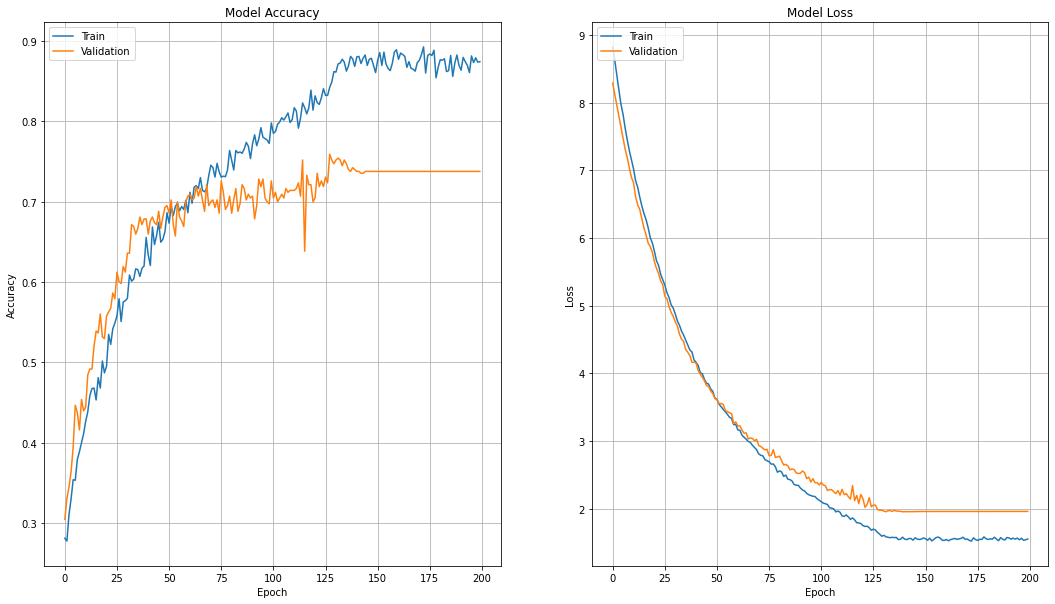

In [48]:
# Plot our loss and accuracy over time
fig, axs = plt.subplots(1,2, figsize=(18, 10))
axs[0].plot(loss_hist.history['categorical_accuracy'])
axs[0].plot(loss_hist.history['val_categorical_accuracy'])
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Model Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper left')
axs[0].grid()
axs[1].plot(loss_hist.history['loss'])
axs[1].plot(loss_hist.history['val_loss'])
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Model Loss')
axs[1].legend(['Train', 'Validation'], loc='upper left')
axs[1].grid()
plt.show()